# Predicción Valores Autos

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Importación Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from scipy.stats import boxcox

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import time

## Preparación de datos

### Importación de Datos

In [4]:
df= pd.read_csv('car_data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


### Datos Duplicados

In [7]:
df[df.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
14266,21/03/2016 19:06,5999,small,2009,manual,80,polo,125000,5,petrol,volkswagen,no,21/03/2016 00:00,0,65529,05/04/2016 20:47
27568,23/03/2016 10:38,12200,bus,2011,manual,125,zafira,40000,10,gasoline,opel,no,23/03/2016 00:00,0,26629,05/04/2016 07:44
31599,03/04/2016 20:41,4950,wagon,2003,auto,170,e_klasse,150000,4,gasoline,mercedes_benz,no,03/04/2016 00:00,0,48432,05/04/2016 21:17
33138,07/03/2016 20:45,10900,convertible,2005,auto,163,clk,125000,5,petrol,mercedes_benz,no,07/03/2016 00:00,0,61200,21/03/2016 03:45
43656,13/03/2016 20:48,4200,sedan,2003,manual,105,golf,150000,10,gasoline,volkswagen,no,13/03/2016 00:00,0,14482,13/03/2016 20:48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349709,03/04/2016 20:52,700,small,1999,manual,60,ibiza,150000,12,petrol,seat,yes,03/04/2016 00:00,0,6268,05/04/2016 21:47
351555,26/03/2016 16:54,3150,bus,2003,manual,86,transit,150000,11,gasoline,ford,no,26/03/2016 00:00,0,96148,02/04/2016 07:47
352384,15/03/2016 21:54,5900,wagon,2006,manual,129,3er,150000,12,petrol,bmw,no,15/03/2016 00:00,0,92526,20/03/2016 21:17
353057,05/03/2016 14:16,9500,small,2013,manual,105,ibiza,40000,5,petrol,seat,no,04/03/2016 00:00,0,61381,05/04/2016 19:18


In [8]:
#Eliminación datos duplicados
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354107 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354107 non-null  object
 1   Price              354107 non-null  int64 
 2   VehicleType        316623 non-null  object
 3   RegistrationYear   354107 non-null  int64 
 4   Gearbox            334277 non-null  object
 5   Power              354107 non-null  int64 
 6   Model              334406 non-null  object
 7   Mileage            354107 non-null  int64 
 8   RegistrationMonth  354107 non-null  int64 
 9   FuelType           321218 non-null  object
 10  Brand              354107 non-null  object
 11  NotRepaired        282962 non-null  object
 12  DateCreated        354107 non-null  object
 13  NumberOfPictures   354107 non-null  int64 
 14  PostalCode         354107 non-null  int64 
 15  LastSeen           354107 non-null  object
dtypes: int64(7), object(9)
me

### Datos Faltantes

#### Columna Vehicle Type

In [9]:
df[df['VehicleType'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
16,01/04/2016 12:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,01/04/2016 00:00,0,38871,01/04/2016 12:46
22,23/03/2016 14:52,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,23/03/2016 00:00,0,49716,31/03/2016 01:16
26,10/03/2016 19:38,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,10/03/2016 00:00,0,31139,16/03/2016 09:16
31,29/03/2016 16:57,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,29/03/2016 00:00,0,37075,29/03/2016 17:43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354346,07/03/2016 17:06,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,07/03/2016 00:00,0,61169,08/03/2016 21:28
354351,11/03/2016 23:40,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,11/03/2016 00:00,0,87700,12/03/2016 14:16
354361,09/03/2016 13:37,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,09/03/2016 00:00,0,51371,13/03/2016 01:44
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42


- La cantidad de valores faltantes en la columna 'VehicleType' es aproximadamente el 10% de los datos.
- Se buscó dentro del resto de columnas posibles indicios que permitan completar el tipo de vehículo, por ejemplo usar el modelo, sin embargo, cada modelo tiene muchos tipos de vehículo asignado.
- Se procede a eliminar las filas ya que no se puede imputar información fiable. 

#### Columna GearBox

In [10]:
df[df['Gearbox'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
15,11/03/2016 21:39,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,11/03/2016 00:00,0,24148,19/03/2016 08:46
16,01/04/2016 12:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,01/04/2016 00:00,0,38871,01/04/2016 12:46
32,15/03/2016 20:59,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,15/03/2016 00:00,0,44145,17/03/2016 18:17
37,28/03/2016 17:50,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,28/03/2016 00:00,0,46483,30/03/2016 09:18
40,26/03/2016 22:06,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,26/03/2016 00:00,0,56412,27/03/2016 17:43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,16/03/2016 13:36,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,16/03/2016 00:00,0,12057,17/03/2016 12:17
354305,03/04/2016 13:46,3500,NaN,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,03/04/2016 00:00,0,74579,05/04/2016 12:44
354329,30/03/2016 20:55,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,30/03/2016 00:00,0,25436,07/04/2016 13:50
354338,31/03/2016 19:52,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,31/03/2016 00:00,0,41470,06/04/2016 14:18


- No se pueden imputar datos, puesto que no se conoce si la caja de cambios es manual o automática para cada modelo.
- La cantidad de datos faltantes es cerca del 5% de la cantidad total.

#### Columna Model

In [11]:
df[df['Model'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
59,29/03/2016 15:48,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,29/03/2016 00:00,0,53721,06/04/2016 01:44
81,03/04/2016 12:56,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,03/04/2016 00:00,0,45665,05/04/2016 11:47
115,20/03/2016 18:53,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,20/03/2016 00:00,0,37520,07/04/2016 02:45
135,27/03/2016 20:51,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,27/03/2016 00:00,0,38709,05/04/2016 20:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354245,07/03/2016 16:37,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,07/03/2016 00:00,0,55743,12/03/2016 21:45
354321,15/03/2016 13:52,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,15/03/2016 00:00,0,91186,17/03/2016 08:16
354338,31/03/2016 19:52,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,31/03/2016 00:00,0,41470,06/04/2016 14:18
354351,11/03/2016 23:40,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,11/03/2016 00:00,0,87700,12/03/2016 14:16


- No se pueden imputar datos, puesto que no se conoce el modelo a pesar de conocer la marca o el tipo de vehículo.
- La cantidad de datos faltantes es cerca del 5% de la cantidad total.

#### Columna Fuel Type

In [12]:
df[df['FuelType'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,0,27472,31/03/2016 17:17
13,21/03/2016 21:37,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no,21/03/2016 00:00,0,90762,23/03/2016 02:50
26,10/03/2016 19:38,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,10/03/2016 00:00,0,31139,16/03/2016 09:16
36,11/03/2016 11:50,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,11/03/2016 00:00,0,2943,07/04/2016 03:46
41,30/03/2016 20:38,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN,30/03/2016 00:00,0,33649,03/04/2016 11:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354339,20/03/2016 12:46,3850,convertible,2006,manual,108,2_reihe,125000,2,NaN,peugeot,no,20/03/2016 00:00,0,53947,26/03/2016 21:18
354346,07/03/2016 17:06,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,07/03/2016 00:00,0,61169,08/03/2016 21:28
354351,11/03/2016 23:40,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,11/03/2016 00:00,0,87700,12/03/2016 14:16
354361,09/03/2016 13:37,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,09/03/2016 00:00,0,51371,13/03/2016 01:44


- No se pueden imputar datos, puesto que no se conoce el tipo de combustible que utiliza cada auto.
- La cantidad de datos faltantes es cerca del 9% de la cantidad total.

#### Columna Not Repaired

In [13]:
df[df['NotRepaired'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
8,04/04/2016 23:42,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,04/04/2016 00:00,0,94505,04/04/2016 23:42
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,0,27472,31/03/2016 17:17
12,15/03/2016 22:49,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,15/03/2016 00:00,0,37269,01/04/2016 13:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354349,16/03/2016 17:06,5999,wagon,2005,manual,140,a4,150000,4,gasoline,audi,NaN,16/03/2016 00:00,0,56472,18/03/2016 11:30
354356,04/04/2016 11:45,999,convertible,2000,manual,95,megane,150000,4,petrol,renault,NaN,04/04/2016 00:00,0,88477,06/04/2016 12:44
354357,09/03/2016 11:36,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,NaN,09/03/2016 00:00,0,18246,04/04/2016 08:15
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46


- No se pueden imputar datos, puesto que no se conoce si cada auto ha sido reparado.
- La cantidad de datos faltantes es cerca del 20% de la cantidad total.

#### Eliminación de datos

In [14]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245567 entries, 3 to 354367
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        245567 non-null  object
 1   Price              245567 non-null  int64 
 2   VehicleType        245567 non-null  object
 3   RegistrationYear   245567 non-null  int64 
 4   Gearbox            245567 non-null  object
 5   Power              245567 non-null  int64 
 6   Model              245567 non-null  object
 7   Mileage            245567 non-null  int64 
 8   RegistrationMonth  245567 non-null  int64 
 9   FuelType           245567 non-null  object
 10  Brand              245567 non-null  object
 11  NotRepaired        245567 non-null  object
 12  DateCreated        245567 non-null  object
 13  NumberOfPictures   245567 non-null  int64 
 14  PostalCode         245567 non-null  int64 
 15  LastSeen           245567 non-null  object
dtypes: int64(7), object(9)
me

### Tipos de Datos

#### Columna Date Crawled

In [15]:
#Transformación a tipo fecha
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
print(df['DateCrawled'].dt.year.unique())
print(df['DateCrawled'].dt.month.unique())
print(df['DateCrawled'].dt.day.unique())
print(df['DateCrawled'].dt.day.unique())
print(df['DateCrawled'].dt.hour.unique())

[2016]
[3 4]
[17 31  4  1 21 26  7 20 23 27 12 13 18  9  8  3 25 29 15 22 30  5 11 10
 28  2 14 16 19 24  6]
[17 31  4  1 21 26  7 20 23 27 12 13 18  9  8  3 25 29 15 22 30  5 11 10
 28  2 14 16 19 24  6]
[16 17 20 18 19 10 12 15 22 11 21  0 14  8  1  9 13  7 23  6  2  4  3  5]


/tmp/ipykernel_16424/3693515156.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])


Separamos en 3 columnas que representan al mes, día y hora. 
El año se descarta por ser solo 2016

In [16]:
#Separación en Columnas
df['DateCrawledMonth'] = df['DateCrawled'].dt.month
df['DateCrawledDay'] = df['DateCrawled'].dt.day
df['DateCrawledHour'] = df['DateCrawled'].dt.hour
df.drop(columns='DateCrawled',inplace=True)

#### Columna Date Created

In [17]:
#Transformación a tipo fecha
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
print(df['DateCreated'].dt.year.unique())
print(df['DateCreated'].dt.month.unique())
print(df['DateCreated'].dt.day.unique())
print(df['DateCreated'].dt.hour.unique())

[2016 2015]
[ 3  4  2 11 12  1  9  8]
[17 31  4  1 21 26  7 20 23 27 12 13 18  9  8  3 25 29 15 22 30  5 11 10
 28  2 14 16 19 24  6]
[0]


/tmp/ipykernel_16424/3249906139.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DateCreated'] = pd.to_datetime(df['DateCreated'])


Separamos en 3 columnas que representan al año,mes y día. Se descarta la hora porque todas son 0 

In [18]:
#Separación en Columnas
df['DateCreatedYear'] = df['DateCreated'].dt.year
df['DateCreatedMonth'] = df['DateCreated'].dt.month
df['DateCreatedDay'] = df['DateCreated'].dt.day
df.drop(columns='DateCreated',inplace=True)

#### Columna Last Seen

In [19]:
#Transformación a tipo fecha
df['LastSeen'] = pd.to_datetime(df['LastSeen'])
print(df['LastSeen'].dt.year.unique())
print(df['LastSeen'].dt.month.unique())
print(df['LastSeen'].dt.day.unique())
print(df['LastSeen'].dt.hour.unique())

[2016]
[3 4]
[17  6  5 25  7 21 13 18 26 10  9 30 27 29 16  1 22 11 15 31 12 23  2 20
 24  3  4 14 19 28  8]
[17 10 19 18 16  7 13 22  6  1 20 21  9 11 15  4 12  3  8 23 14  0  2  5]


/tmp/ipykernel_16424/2005253164.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['LastSeen'] = pd.to_datetime(df['LastSeen'])


Separamos en 3 columnas que representan al mes, día y hora. 
El año se descarta por ser solo 2016

In [20]:
#Separación en Columnas
df['LastSeenMonth'] = df['LastSeen'].dt.month
df['LastSeenDay'] = df['LastSeen'].dt.day
df['LastSeenHour'] = df['LastSeen'].dt.hour
df.drop(columns='LastSeen',inplace=True)

In [21]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,...,PostalCode,DateCrawledMonth,DateCrawledDay,DateCrawledHour,DateCreatedYear,DateCreatedMonth,DateCreatedDay,LastSeenMonth,LastSeenDay,LastSeenHour
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,...,91074,3,17,16,2016,3,17,3,17,17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,...,60437,3,31,17,2016,3,31,4,6,10
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,...,33775,4,4,17,2016,4,4,4,6,19
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,...,67112,4,1,20,2016,4,1,4,5,18
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,...,19348,3,21,18,2016,3,21,3,25,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,...,81825,4,2,20,2016,4,2,4,6,20
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,...,96465,3,19,19,2016,3,19,3,19,20
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,...,26624,3,27,20,2016,3,27,3,29,10
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,...,26135,3,5,19,2016,3,5,3,11,18


### Datos Inconsistentes en el target

In [27]:
df['Price'].describe()

count    245567.000000
mean       5125.680959
std        4718.468928
min           0.000000
25%        1499.000000
50%        3500.000000
75%        7500.000000
max       20000.000000
Name: Price, dtype: float64

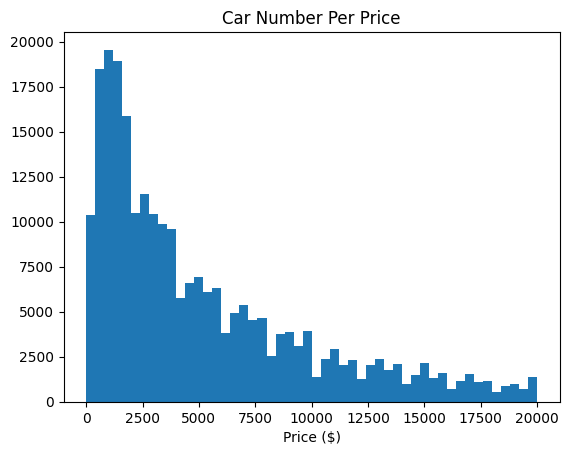

In [28]:
plt.hist(df['Price'],bins=50)
plt.title('Car Number Per Price')
plt.xlabel('Price ($)')
plt.show()

De acuerdo al los datos vistos anteriormente, existen autos con precio de 0 o 1 (e incrementando a partir de ahí), lo cual no tiene sentido en el contexto de venta de autos.
Estos datos deben tener un valor erróneo por diferentes motivos, pero no deberían ser tomados en cuenta para no confundir al modelo, ya que nunca debería predecir un valor tan bajo.
En base a esto, podríamos eliminar todos los datos cuyo precio esté bajo un umbral, en este caso voy a establecerlo en 100.

In [31]:
#Eliminación filas con precio menor a 100
df.drop(df[df['Price']<100].index,axis=0,inplace=True)
df = df.reset_index(drop = True)
#Comprobación estadísticas de Price 
df['Price'].describe()

count    241548.000000
mean       5210.891057
std        4710.704773
min         100.000000
25%        1500.000000
50%        3500.000000
75%        7500.000000
max       20000.000000
Name: Price, dtype: float64

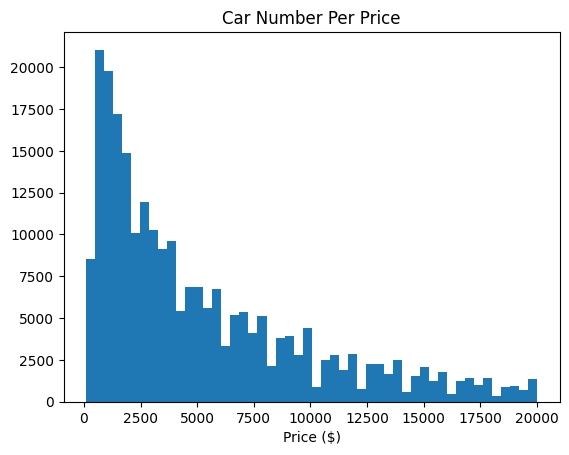

In [32]:
plt.hist(df['Price'],bins=50)
plt.title('Car Number Per Price')
plt.xlabel('Price ($)')
plt.show()

Se evidencia que el target tiene un sesgo, por lo que conviene escalarlo para que su distribución se aproxime de mejor forma a una normal, ya que vamos a plantear un modelo de regresión.

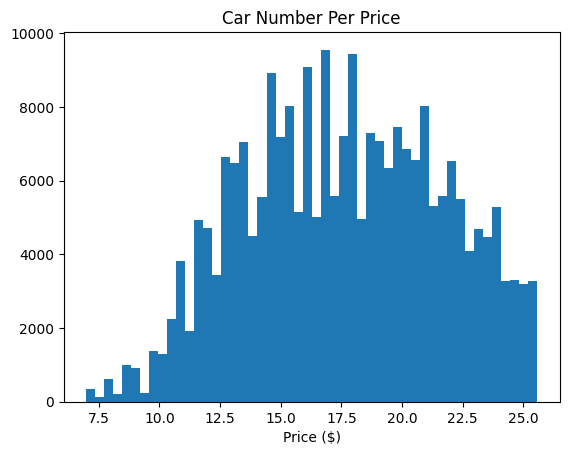

In [33]:
#Escalamiento Boxcox para normalizar el target
df['PriceScaled'], _ = boxcox(df['Price'] + 1)

#Graficamos la nueva distribución
plt.hist(df['PriceScaled'],bins=50)
plt.title('Car Number Per Price')
plt.xlabel('Price ($)')
plt.show()

Con esta herramienta, podemos decir que nuestra distribución se aproxima a una normal.

### Eliminación Columna sin datos

In [34]:
#Comprobación de los distintos valores que tiene NumberOfPictures
df['NumberOfPictures'].value_counts()

NumberOfPictures
0    241548
Name: count, dtype: int64

In [35]:
#Eliminación
df.drop(columns='NumberOfPictures',axis=1,inplace=True)

### Codificación Variables Categóricas

Vamos a analizar la cantidad de categorías para elegir el tipo de codificación de las columnas categóricas:

In [36]:
# Número de catergorías por cada columna
print('VehicleType:',df['VehicleType'].nunique())
print('Gearbox:',df['Gearbox'].nunique())
print('Model:',df['Model'].nunique())
print('FuelType:',df['FuelType'].nunique())
print('Brand:',df['Brand'].nunique())
print('NotRepaired:',df['NotRepaired'].nunique())
print('PostalCode:',df['PostalCode'].nunique())

VehicleType: 8
Gearbox: 2
Model: 249
FuelType: 7
Brand: 39
NotRepaired: 2
PostalCode: 8068


Para evitar aumentar en exceso la dimensionalidad, las columnas 'VehicleType','Model','Brand','PostalCode', se va a codifcar ordinalmente junto a las columnas con datos de fechas.
El resto se va a codificar con OHE.

*Codificación OHE*

In [39]:
cod_ohe = ['VehicleType','Model','Brand','Gearbox','FuelType','DateCreatedYear','NotRepaired']

In [40]:
df_ohe = pd.get_dummies(df,columns=cod_ohe,drop_first=True)
df_ohe

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,PostalCode,DateCrawledMonth,DateCrawledDay,DateCrawledHour,DateCreatedMonth,...,Brand_volvo,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,DateCreatedYear_2016,NotRepaired_yes
0,1500,2001,75,150000,6,91074,3,17,16,3,...,False,True,False,False,False,False,False,True,True,False
1,3600,2008,69,90000,7,60437,3,31,17,3,...,False,True,False,True,False,False,False,False,True,False
2,650,1995,102,150000,10,33775,4,4,17,4,...,False,True,False,False,False,False,False,True,True,True
3,2200,2004,109,150000,8,67112,4,1,20,4,...,False,True,False,False,False,False,False,True,True,False
4,2000,2004,105,150000,12,96224,3,26,19,3,...,False,True,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241543,3999,2005,3,150000,5,81825,4,2,20,4,...,False,True,False,True,False,False,False,False,True,False
241544,3200,2004,225,150000,5,96465,3,19,19,3,...,False,True,False,False,False,False,False,True,True,True
241545,1150,2000,0,150000,3,26624,3,27,20,3,...,False,True,False,False,False,False,False,True,True,False
241546,1199,2000,101,125000,3,26135,3,5,19,3,...,False,False,False,False,False,False,False,True,True,False


*Codificación Ordinal*

In [41]:
# Columnas para ser codificadas
cat_ord = ['RegistrationYear','RegistrationMonth','PostalCode','DateCrawledMonth','DateCrawledDay','DateCrawledHour','DateCreatedMonth','DateCreatedDay','LastSeenMonth','LastSeenDay','LastSeenHour','PostalCode']

In [ ]:
# Entrenamiento y codificación Ordinal
encoder = OrdinalEncoder()
df_ohe[cat_ord]= encoder.fit_transform(df_ohe[cat_ord])
df_ohe

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,PostalCode,DateCrawledMonth,DateCrawledDay,DateCrawledHour,DateCreatedMonth,...,Brand_volvo,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,DateCreatedYear_2016,NotRepaired_yes
0,1500,63.0,75,150000,6.0,6970.0,0.0,16.0,16.0,2.0,...,False,True,False,False,False,False,False,True,True,False
1,3600,70.0,69,90000,7.0,4166.0,0.0,30.0,17.0,2.0,...,False,True,False,True,False,False,False,False,True,False
2,650,57.0,102,150000,10.0,2338.0,1.0,3.0,17.0,3.0,...,False,True,False,False,False,False,False,True,True,True
3,2200,66.0,109,150000,8.0,4589.0,1.0,0.0,20.0,3.0,...,False,True,False,False,False,False,False,True,True,False
4,2000,66.0,105,150000,12.0,7681.0,0.0,25.0,19.0,2.0,...,False,True,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241543,3999,67.0,3,150000,5.0,5857.0,1.0,1.0,20.0,3.0,...,False,True,False,True,False,False,False,False,True,False
241544,3200,66.0,225,150000,5.0,7714.0,0.0,18.0,19.0,2.0,...,False,True,False,False,False,False,False,True,True,True
241545,1150,62.0,0,150000,3.0,1829.0,0.0,26.0,20.0,2.0,...,False,True,False,False,False,False,False,True,True,False
241546,1199,62.0,101,125000,3.0,1791.0,0.0,4.0,19.0,2.0,...,False,False,False,False,False,False,False,True,True,False


In [43]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241548 entries, 0 to 241547
Columns: 317 entries, Price to NotRepaired_yes
dtypes: bool(302), float64(12), int64(3)
memory usage: 97.2 MB


### Estandarización

In [49]:
# Columnas para ser estandarizadas
variables = ['RegistrationYear','Power','Mileage','RegistrationMonth',
             'PostalCode','DateCrawledMonth','DateCrawledDay', 'DateCrawledHour'
             ,'DateCreatedMonth','DateCreatedDay','LastSeenMonth','LastSeenDay','LastSeenHour']

Se utiliza Min_Max Scaler debido a que nos brinda un rango entre 0 y 1, lo cual coincide con la codificación ohe. De esta manera todos los datos se encuentran dentro del mismo rango

In [50]:
# Entrenamiento y estandarización
scaler = MinMaxScaler()
scaler.fit(df_ohe[variables])
df_ohe[variables] = scaler.transform(df_ohe[variables])

<div class="alert alert-block alert-success">
<b>Comentario del revisor. (Iteración 1) </b> <a class="tocSkip"></a>

Aquí valdría la pena ver la justificación de la elección de minmax scaler.

In [51]:
df_ohe

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,PostalCode,DateCrawledMonth,DateCrawledDay,DateCrawledHour,DateCreatedMonth,...,Brand_volvo,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,DateCreatedYear_2016,NotRepaired_yes
0,1500,0.7875,0.00375,1.000000,0.500000,0.864014,0.0,0.533333,0.695652,0.285714,...,False,True,False,False,False,False,False,True,True,False
1,3600,0.8750,0.00345,0.586207,0.583333,0.516425,0.0,1.000000,0.739130,0.285714,...,False,True,False,True,False,False,False,False,True,False
2,650,0.7125,0.00510,1.000000,0.833333,0.289823,1.0,0.100000,0.739130,0.428571,...,False,True,False,False,False,False,False,True,True,True
3,2200,0.8250,0.00545,1.000000,0.666667,0.568861,1.0,0.000000,0.869565,0.428571,...,False,True,False,False,False,False,False,True,True,False
4,2000,0.8250,0.00525,1.000000,1.000000,0.952151,0.0,0.833333,0.826087,0.285714,...,False,True,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241543,3999,0.8375,0.00015,1.000000,0.416667,0.726044,1.0,0.033333,0.869565,0.428571,...,False,True,False,True,False,False,False,False,True,False
241544,3200,0.8250,0.01125,1.000000,0.416667,0.956241,0.0,0.600000,0.826087,0.285714,...,False,True,False,False,False,False,False,True,True,True
241545,1150,0.7750,0.00000,1.000000,0.250000,0.226726,0.0,0.866667,0.869565,0.285714,...,False,True,False,False,False,False,False,True,True,False
241546,1199,0.7750,0.00505,0.827586,0.250000,0.222016,0.0,0.133333,0.826087,0.285714,...,False,False,False,False,False,False,False,True,True,False


### Separación Train - Test

In [52]:
features = df_ohe.drop(columns=['Price','PriceScaled'],axis=1)
target = df_ohe['PriceScaled']

In [53]:
#Separación en dos grupos 75%-25%
features_train,features_test,target_train,target_test = train_test_split (features,target,test_size=0.25,random_state=1234)

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(181161, 315)
(60387, 315)
(181161,)
(60387,)


## Entrenamiento del modelo 

### Regresión Lineal

In [54]:

start_time = time.time()
#Entrenamiento
regresion = LinearRegression ()
regresion.fit(features_train,target_train)
#Predicción
target_predicted = regresion.predict(features_test)
#Métricas
recm_line = mean_squared_error(target_test,target_predicted)**0.5
#Cálculo Tiempo
time_line = time.time()-start_time

print(f"RECM Regresión Lineal: {recm_line:.3f}")
print(f"Tiempo de ejecución Regresión Lineal: {time_line:.3f} segundos")

RECM Regresión Lineal: 2.109
Tiempo de ejecución Regresión Lineal: 10.790 segundos


### Bosque Aleatorio

In [55]:
#Variable RECM
recm_bosque = 50

start_time = time.time()
#Lazo de prueba de hiperparámetros
for i in range (30,120,30):
    for j in range(1,10,5):
        bosque = RandomForestRegressor (n_estimators=i, max_depth=j,random_state=1234)
        #Entrenamiento
        bosque.fit(features_train,target_train)
        #Predicción
        target_predicted = bosque.predict(features_test)
        #Métricas
        recm = mean_squared_error(target_test,target_predicted)**0.5
        if recm < recm_bosque:
            recm_bosque = recm
#Cálculo Tiempo
time_arbol = time.time()-start_time

print(f"RECM Bosque Aleatorio: {recm_bosque:.3f}")
print(f"Tiempo de ejecución Random Forest: {time_arbol:.3f} segundos")

RECM Bosque Aleatorio: 1.940
Tiempo de ejecución Random Forest: 259.051 segundos


### LightGBM

In [56]:
#Variable RECM
recm_lgbm = 100

start_time = time.time()
#Lazo de prueba de hiperparámetros
for r in range(1,50,10):
    for n in range(50,150,50):
        #Entrenamiento
        lgbm = LGBMRegressor(learning_rate=(r/10), n_estimators=n, random_state=1234,
                             verbose = -1).fit(features_train,target_train)

        #Predicción
        target_predicted = lgbm.predict(features_test)
        #Métricas
        recm = mean_squared_error(target_test,target_predicted)**0.5
        if recm < recm_lgbm:
            recm_lgbm = recm

#Cálculo Tiempo
time_lgbm = time.time()-start_time

print(f"RECM LightGBM: {recm_lgbm:.3f}")
print(f"Tiempo de ejecución LightGBM: {time_lgbm:.3f} segundos")

RECM LightGBM: 1.427
Tiempo de ejecución LightGBM: 13.339 segundos


### CatBoost

In [57]:
#Variable RECM
recm_cat = 100

start_time = time.time()
#Lazo de prueba de hiperparámetros
for i in range(500,1000,100):
    for l in range(1,5,1):
        for d in range(0,10,5):
            catboost = CatBoostRegressor(
                iterations= i, #1000,          
                learning_rate= l/10,#0.1,        
                depth= d,#10,                 
                verbose= 0 
                #cat_features=categorical_features,
                ).fit(features_train,target_train)
            
            #Predicción
            target_predicted = catboost.predict(features_test)
            #Métricas
            recm = mean_squared_error(target_test,target_predicted)**0.5
            if recm < recm_cat:
                recm_cat = recm
#Cálculo Tiempo
time_cat = time.time()-start_time

print(f"RECM Catboost: {recm_cat:.3f}")
print(f"Tiempo de ejecución Catboost: {time_cat:.3f} segundos")

RECM Catboost: 1.332
Tiempo de ejecución Catboost: 312.239 segundos


## Análisis del modelo

- Comparando los modelos en base a la métrica RECM, podemos observar que se cumple lo esperado. Es decir, el RECM es mayor en la predicción de la regresión lineal, y disminuye a medida que implementamos modelos mas complejos como el bosque aleatorio, y los modelos de potenciación de gradiente.
- De igual manera, podemos observar que esta reducción de error va a acompañado de un mayor costo computacional, por ende, el tiempo de ejecución crece, y varía sobre todo por la cantidad de hiper parámetros que vamos a probar.
- Podemos ver el resumen en el siguiente cuadro:

In [59]:
resumen = pd.DataFrame({'RECM':[recm_line,recm_bosque,recm_lgbm,recm_cat],
                       'Ejecucion':[time_line,time_arbol,time_lgbm,time_cat]},
                      index=['Regresión Lineal','Random Forest','LightGBM','Catboost'])
resumen

,RECM,Ejecucion
Regresión Lineal,2.108504,10.789892
Random Forest,1.939833,259.051165
LightGBM,1.427039,13.339201
Catboost,1.331640,312.238827


Con base en este cuadro comparativo que toma en cuenta el tiempo de ejecución y el Error cuadrático medio, podemos establecer que el modelo con mejor balance es LightGBM. Mismo que será el escogido.